## Set up

### Package imports

In [73]:
# Import packages
import re
import os
import copy
from pathlib import Path
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import pandas as pd
import random
import datetime
import time
from pdb import set_trace
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, QuantileTransformer
from sklearn.mixture import BayesianGaussianMixture
import scipy.stats as stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import gc

### Define Set

In [74]:
# Both of these sets have protein and mRNA on the same canvas
Set = 'three channel rgb dual'

### Set seed function

In [75]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    rs = RandomState(MT19937(SeedSequence(seed)))

### File path

In [76]:
# File path
raw_data_path = '/home/ec2-user/Feb2025/raw_datasets/'
label_path = '/home/ec2-user/Feb2025/labels/'
output_path = '/home/ec2-user/Feb2025/processed_dataset2/'

### Functions

In [77]:
def Gaussian_KDE(df1, df2, Set):
    """
    Function to generate synthetic data using Gaussian KDE.
    Args:
        df1: DataFrame 1 (e.g., Protein/mRNA abundance for Single set)
        df2: DataFrame 2 (e.g., mRNA abundance for Dual set, optional)
        Set: 'Single' or 'Dual', determines the modeling approach
        Canvas_Size: Target size for the final dataset (rows x columns)
    Returns:
        final_df: Original data with synthetic data appended
    """
    # Placeholder for synthetic data
    synthetic_data = []

    # Assert df1 and df2 have the same number of columns
    assert df1.columns.size == df2.columns.size

    # Transpose the DataFrames for easier column-wise processing
    df1 = df1.T
    df2 = df2.T


    if Set == 'three channel rgb dual': # for protein + mRNA
        for _ in range(int((18 * 18 - df1.index.size * 2) / 2)):
            synthetic_row = []
            for col1, col2 in zip(df1.columns, df2.columns):
                # Get the abundance values for the joint distribution
                x = df1[col1].values
                y = df2[col2].values
                
                # Combine x and y for joint KDE
                data = np.vstack([x, y])
                
                # Fit a joint KDE
                kde = gaussian_kde(data)
                
                # Sample from the joint KDE
                sample = kde.resample(1)
                sampled_x, sampled_y = sample[0][0], sample[1][0]
                
                # Add sampled values to the synthetic row
                synthetic_row.append(sampled_x)  # For protein
                synthetic_row.append(sampled_y)  # For mRNA
            
            synthetic_data.append(synthetic_row)

    # Convert synthetic data to a new DataFrame
    print(Set)
    print('Synthetic data generated')

    # For Dual, split the synthetic data into two parts
    synthetic_df1 = pd.DataFrame([row[::2] for row in synthetic_data], columns=df1.columns)
    synthetic_df2 = pd.DataFrame([row[1::2] for row in synthetic_data], columns=df2.columns)
    # Combine synthetic with original
    final_df1 = pd.concat([df1, synthetic_df1], axis=0)
    final_df2 = pd.concat([df2, synthetic_df2], axis=0)

    final_df1 = final_df1.T
    final_df2 = final_df2.T

    return final_df1, final_df2

In [78]:
def Normalization(df):

    """
    Normalization across tumors in raw data for protein or mRNA expression.
    """
    
    # Normalize Each Gene Across Tumors 
    df = df.div(df.mean(axis=1),axis=0)

    # Normalize Tumors for Cross-Tumor Comparability
    df = df.div(df.median(axis=0), axis=1)

    # Log2 Transformation
    df = np.log2(df)

    return df

In [79]:
def VisualizeData(PD, MD):
    # Create a figure
    plt.figure(figsize=(12, 12))

    # Create a subplot for PD boxplot
    plt.subplot(2, 2, 1)
    plt.boxplot(PD.values)
    plt.title('Proteome')
    plt.xlabel('Tumors')
    plt.ylabel('Abundances')
    plt.xticks([])

    # Create a subplot for MD boxplot
    plt.subplot(2, 2, 2)
    plt.boxplot(MD.values)
    plt.title('Transcriptome')
    plt.xlabel('Tumors')
    plt.ylabel('Abundances')
    plt.xticks([])

    # Create a subplot for PD histogram
    plt.subplot(2, 2, 3)
    plt.hist(PD.values.flatten(), bins=500)
    plt.title('Proteome')
    plt.xlabel('Tumors')
    plt.ylabel('Count')

    # Create a subplot for MD histogram
    plt.subplot(2, 2, 4)
    plt.hist(MD.values.flatten(), bins=500)
    plt.title('Transcriptome')
    plt.xlabel('Tumors')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

## Create dataframes

### Preparing data for Krug

#### Raw data proceesing

In [80]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
#PFP = 'kr_pro_raw copy.csv' # tumor standardized with mean and std, 2-component Gaussian mixture model-based normalization for gene
#PFP = 'kr_pro_raw.csv' # LethioDDA search: proteomics file (genes table) path, normalized by pool, log2 transformed.
PFP = 'krug prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
PD = pd.read_csv(raw_data_path+PFP)

# Indexing and remove NA
PD.index = PD.loc[:,'Index']
PD = PD.loc[:,PD.columns!='Index'] # Shape (12372, 135)
PD.dropna(inplace=True) # Shape (8481, 135)

# Remove tumors that contain keyword 'notinstudy': 3 tumors are not in the study
PD = PD.loc[:,~PD.columns.str.contains('notinstudy')]

# Remove tumors that contain keyword 'Retro': 2 tumors are RetroIR
PD = PD.loc[:,~PD.columns.str.contains('Retro')]

# Find tumors that contain keyword 'REP'
rep_cols = PD.columns[PD.columns.str.contains('REP')]

# Extract tumors' name that has replicates
rep_tumors = set(col.split('.')[0] for col in rep_cols)

# Find columns that match the names in rep_tumors, take average and save it under the tumor name that without REP
for rep_tumor in rep_tumors:
    replicates = PD.columns[PD.columns.str.contains(rep_tumor)]
    PD[rep_tumor] = PD[replicates].mean(axis=1) # Overwrite the original tumor with the average of the replicates
    # Drop the REP column of the rep_tumor only
    replicate_cols = PD.columns[PD.columns.str.contains(rep_tumor+'.REP')]
    PD.drop(replicate_cols, axis=1, inplace=True) # Drop the replicate columns

# Drop tumor X03BR011 because it has no mRNA data
PD.drop('X03BR011', axis=1, inplace=True)

# Sort the column names in the dataframe
PD = PD.reindex(sorted(PD.columns), axis=1) # Shape (8481, 121)

In [81]:
# Open the mRNA data and only keep genes (rows) that are fully quantified
#MFP = 'kr_rna_raw.csv' # mRNA file path, log2 transformed
MFP = 'krug mrna model use.csv' # TPM data, untransformed
MD = pd.read_csv(raw_data_path+MFP)

# Data set wrangling
MD.index = MD.loc[:,'Index']
MD = MD.loc[:,MD.columns!='Index'] # Shape (19938, 121)
MD.dropna(inplace=True) # Shape (19938, 121)

# Drop if any gene that contains 0 read of TPM
MD = MD.loc[~(MD==0).any(axis=1)] # Shape (13627, 121)

# Sort the column names in the dataframe
MD = MD.reindex(sorted(MD.columns), axis=1) # Shape (13627, 121)

#### Normalization

In [82]:
# Visualize the processed data with boxplot and histogram
PD_norm = Normalization(PD)
MD_norm = Normalization(MD)

#### Filter out genes that has labels

In [83]:
# Open the labels data
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [84]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in PD_norm.index if ((value in MD_norm.index) & (value in LD.index))]
PD_norm = PD_norm.loc[IntersectingGenes,:]
MD_norm = MD_norm.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Krug')
print(len(PD_norm.index))
print(len(MD_norm.index))
print(len(LD.index))

Krug
2693
2693
2693


In [85]:
# Count the number of genes in each localization class
LocalizationCounts = LD.loc[:,'Localization'].value_counts()
print('Number of genes in each localization class:')
print(LocalizationCounts)

Number of genes in each localization class:
Localization
Cytosol         1036
Secretory        769
Nucleus          624
Mitochondria     264
Name: count, dtype: int64


#### Inferencing

In [86]:
# Ensure reproducibility
set_seed(42)

# Generate synthetic data using Bayesian Gaussian Mixture Model
# PD_syn, MD_syn = Bayesian_GMM(PD=PD_norm, MD=MD_norm, Set=Set, Rand_State_1=42, Rand_State_2=43, Canvas_Size=18)

# Synthetic tumors using gaussian KDE
PD_norm, MD_norm = Gaussian_KDE(PD_norm, MD_norm, Set)

three channel rgb dual
Synthetic data generated


#### Scaling

In [87]:
#Quantile transformation
PD_norm.columns = PD_norm.columns.astype(str)
MD_norm.columns = MD_norm.columns.astype(str)

# Quantile transform each tumor
PD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=42).fit_transform(PD_norm), index=PD_norm.index, columns=PD_norm.columns)
MD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=43).fit_transform(MD_norm), index=MD_norm.index, columns=MD_norm.columns)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2693). n_quantiles is set to n_samples.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2693). n_quantiles is set to n_samples.
  warnings.warn(


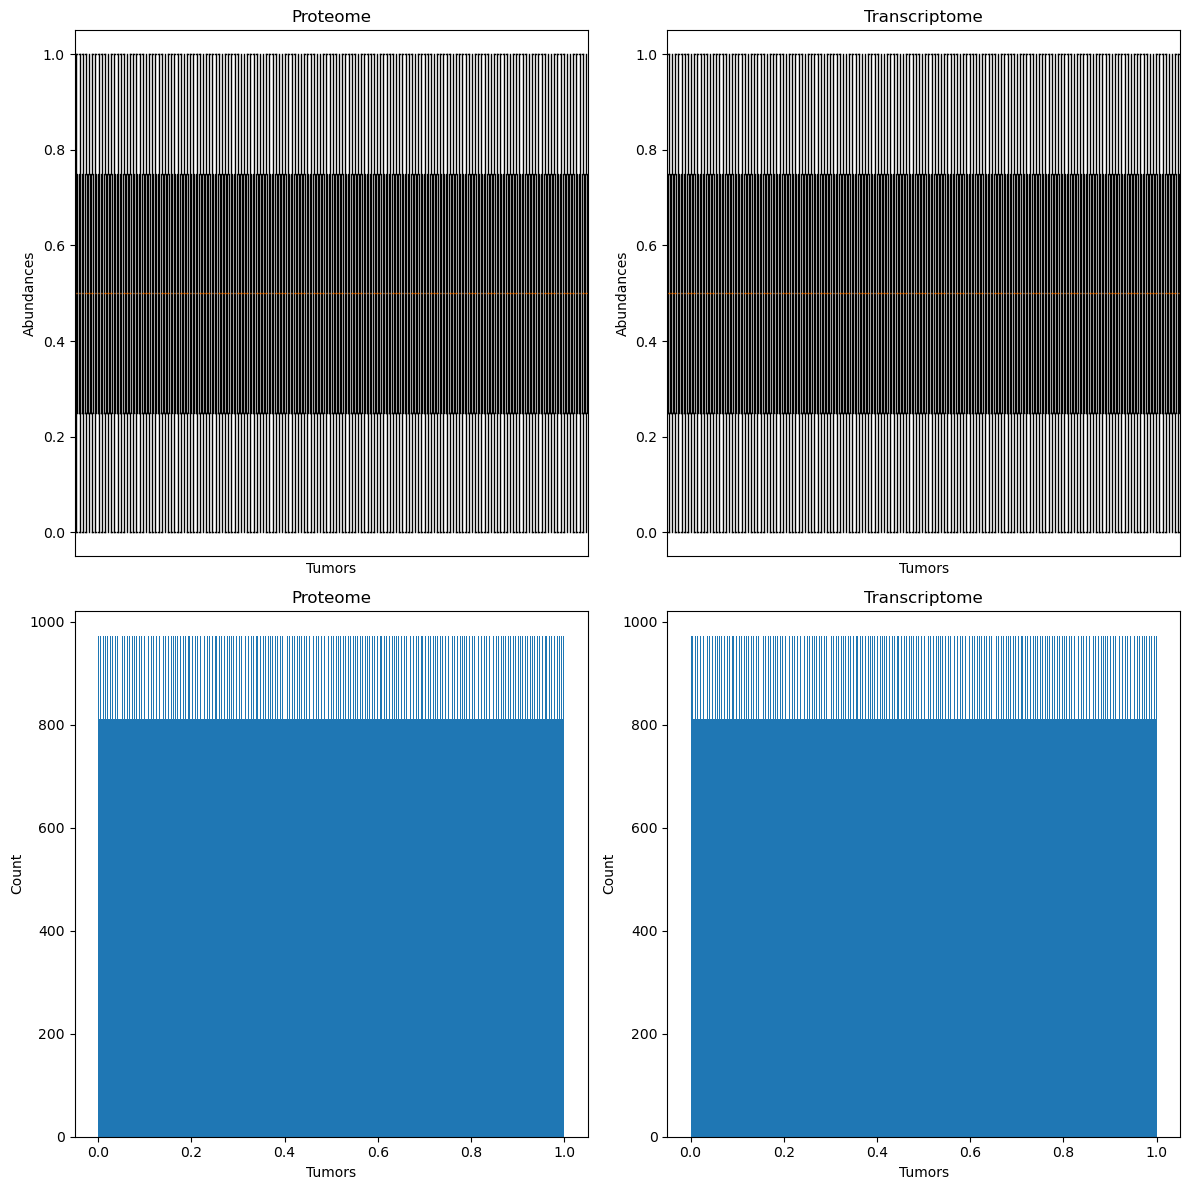

In [88]:
VisualizeData(PD_qt_tumor, MD_qt_tumor)

### Preparing data for Mertins

#### Raw data processing

In [89]:
# Mertins data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
#M_PFP = 'me_protein_dropna.csv' # proteomics file path, normalized by pool, log2 transformed.
M_PFP = 'mertins prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
M_PD = pd.read_csv(raw_data_path+M_PFP)

# Data set wrangling
M_PD.index = M_PD.loc[:,'Index']
M_PD = M_PD.loc[:,M_PD.columns!='Index'] # Shape (12302, 111)
M_PD.dropna(inplace=True) # Shape (7064, 111)

# Remove tumors that contain keyword 'notinstudy': 28 tumors are not in the study
M_PD = M_PD.loc[:,~M_PD.columns.str.contains('notinstudy')]

# Find tumors that contain keyword 'REP'
M_PD_rep_cols = M_PD.columns[M_PD.columns.str.contains('REP')]

# Extract tumors' name that has replicates
M_PD_rep_tumors = set(col.split('.')[0] for col in M_PD_rep_cols)

# Find columns that match the names in rep_tumors, take average and save it under the tumor name that without REP
for M_PD_rep_tumor in M_PD_rep_tumors:
    M_PD_replicates = M_PD.columns[M_PD.columns.str.contains(M_PD_rep_tumor)]
    M_PD[M_PD_rep_tumor] = M_PD[M_PD_replicates].mean(axis=1) # Overwrite the original tumor with the average of the replicates
    # Drop the REP column of the rep_tumor only
    M_PD_replicate_cols = M_PD.columns[M_PD.columns.str.contains(M_PD_rep_tumor+'.REP')]
    M_PD.drop(M_PD_replicate_cols, axis=1, inplace=True) # Drop the replicate columns

# Sort the column names in the dataframe
M_PD = M_PD.reindex(sorted(M_PD.columns), axis=1) # Shape (7064, 77)

In [90]:
# Open the mRNA data and only keep genes (rows) that are fully quantified
#M_MFP = 'me_rna_dropna.csv' # mRNA file path, gene centric median normalized, log2 transformed
M_MFP = 'mertins mrna model use.csv' # TPM data, untransformed
M_MD = pd.read_csv(raw_data_path+M_MFP)

# Data set wrangling
M_MD.index = M_MD.loc[:,'gene_name']
M_MD = M_MD.loc[:,M_MD.columns!='gene_name'] # Shape (19938, 77)

#M_MD = M_MD.drop_duplicates() # Shape (19292, 77)

M_MD.dropna(inplace=True) # Shape (19292, 77)

# Drop if any gene that contains 0 read of TPM (5063 genes are dropped, still have 6706 in common with PD)
M_MD = M_MD.loc[~(M_MD==0).any(axis=1)] # Shape (14229, 77)

# Sort the column names in the dataframe
M_MD = M_MD.reindex(sorted(M_MD.columns), axis=1) # Shape (14229, 77)


#### Normalization

In [91]:
# Visualize the processed data with boxplot and histogram
M_PD_norm = Normalization(M_PD)
M_MD_norm = Normalization(M_MD)

#### Filter out genes that has labels

In [92]:
# Open the labels data
LFP = 'markers.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [93]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in M_PD_norm.index if ((value in M_MD_norm.index) & (value in LD.index))]
M_PD_norm = M_PD_norm.loc[IntersectingGenes,:]
M_MD_norm = M_MD_norm.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Mertin')
print(len(M_PD_norm.index))
print(len(M_MD_norm.index))
print(len(LD.index))

Mertin
2355
2355
2355


In [94]:
# Count the number of genes in each localization class
LocalizationCounts = LD.loc[:,'Localization'].value_counts()
print('Number of genes in each localization class:')
print(LocalizationCounts)

Number of genes in each localization class:
Localization
Cytosol         982
Secretory       580
Nucleus         550
Mitochondria    243
Name: count, dtype: int64


#### Inferencing

In [95]:
# Ensure reproducibility
set_seed(44)

# Synthetic tumors using gaussian KDE
M_PD_norm, M_MD_norm = Gaussian_KDE(M_PD_norm, M_MD_norm, Set)

three channel rgb dual
Synthetic data generated


#### Scaling

In [96]:
#Quantile transformation
M_PD_norm.columns = M_PD_norm.columns.astype(str)
M_MD_norm.columns = M_MD_norm.columns.astype(str)

# Quantile transform each tumor
M_PD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=44).fit_transform(M_PD_norm), index=M_PD_norm.index, columns=M_PD_norm.columns)
M_MD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=45).fit_transform(M_MD_norm), index=M_MD_norm.index, columns=M_MD_norm.columns)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2355). n_quantiles is set to n_samples.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2355). n_quantiles is set to n_samples.
  warnings.warn(


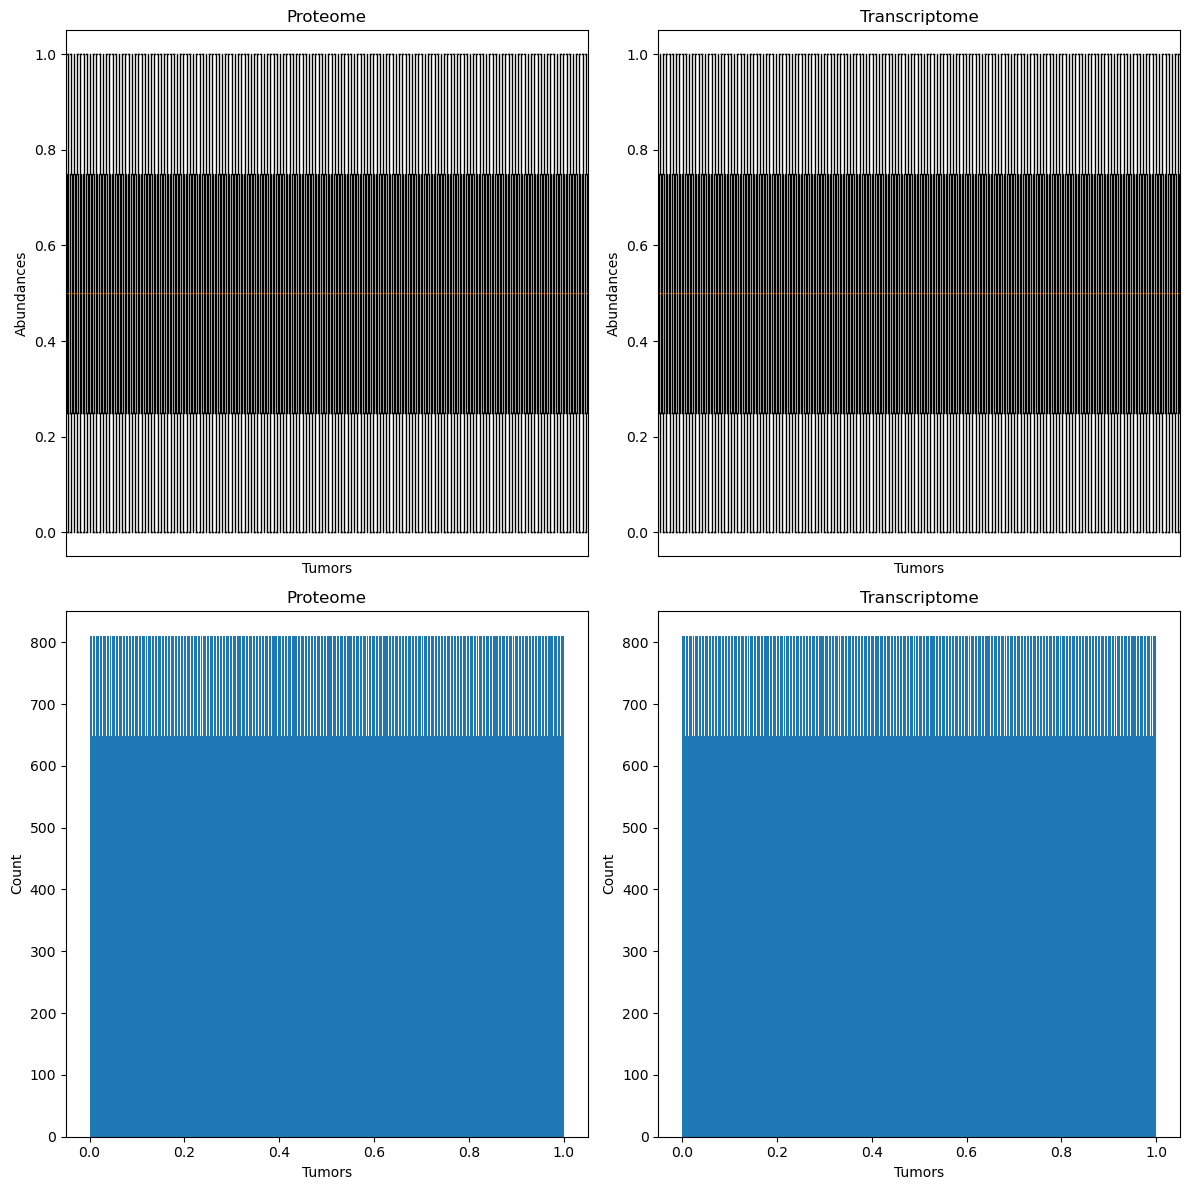

In [97]:
VisualizeData(M_PD_qt_tumor, M_MD_qt_tumor)

### Preparing data for Johansson

#### Raw data processing

In [ ]:
# Johansson data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
#J_PFP = 'jo_protein_log2.csv' # proteomics file path, normalized by pool, log2 transformed.
J_PFP = 'johansson prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
J_PD = pd.read_csv(raw_data_path+J_PFP)

# Sort the column names in the dataframe
J_PD = J_PD.reindex(sorted(J_PD.columns), axis=1)

# # Data set wrangling
J_PD.index = J_PD.loc[:,'Index']
J_PD = J_PD.loc[:,J_PD.columns!='Index'] # Shape (12811, 45)
J_PD.dropna(inplace=True) # Shape (10559, 45)

# Open the mRNA data and only keep genes (rows) that are fully quantified
J_MFP = 'jo_mrna_dropna_newtumorid.csv' # mRNA file path, gene centric median normalized, log2 transformed
J_MD = pd.read_csv(raw_data_path + J_MFP)

# Sort the column names in both dataframe
J_MD = J_MD.reindex(sorted(J_MD.columns), axis=1)

# Data set wrangling
J_MD.index = J_MD.loc[:,'Unnamed: 0']
J_MD = J_MD.loc[:,J_MD.columns!='Unnamed: 0'] # Shape (32369, 45)
J_MD.dropna(inplace=True) # (32368, 45)

# unlog the data
J_MD = 2**J_PD

#### Normalization

In [ ]:
J_PD_norm = Normalization(J_PD)
J_MD_norm = Normalization(J_MD)

#### Filter out genes that has labels

In [ ]:
# Open the labels data
LFP = 'markers_mcf7_all.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [ ]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in J_PD_norm.index if ((value in J_MD_norm.index) & (value in LD.index))]

# trying to use the common genes between johansson and mertins datasets to filter
#IntersectingGenes = [value for value in M_PD_norm.index if ((value in M_MD_norm.index) & (value in J_MD_norm.index) & (value in J_PD_norm.index) & (value in LD.index))]

J_PD_norm = J_PD_norm.loc[IntersectingGenes,:]
J_MD_norm = J_MD_norm.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Johansson')
print(len(J_PD_norm.index))
print(len(J_MD_norm.index))
print(len(LD.index))

Johansson
5520
5520
5520


#### Inferencing

In [120]:
# Ensure reproducibility
set_seed(43)

# Synthetic tumors using gaussian KDE
J_PD_norm, J_MD_norm = Gaussian_KDE(J_PD_norm, J_MD_norm, Set)

three channel rgb single
Synthetic data generated


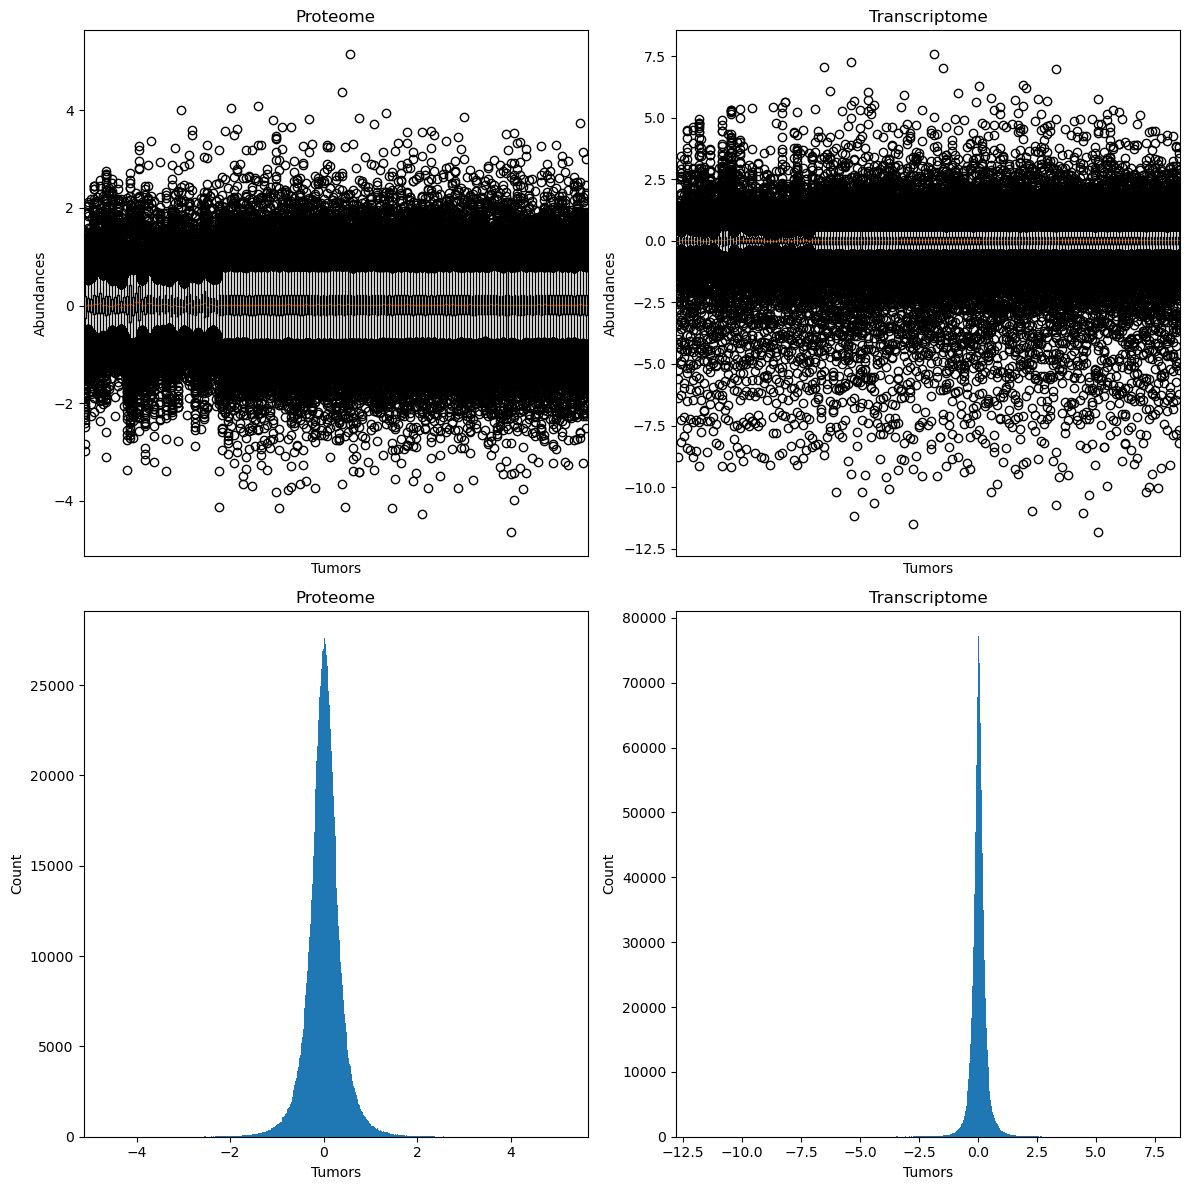

In [121]:
VisualizeData(J_PD_norm, J_MD_norm)

#### Scaling

In [122]:
#Quantile transformation
J_PD_norm.columns = J_PD_norm.columns.astype(str)
J_MD_norm.columns = J_MD_norm.columns.astype(str)

# Quantile transform each gene
#J_PD_qt_gene = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=42).fit_transform(J_PD_norm.T), index=J_PD_norm.T.index, columns=J_PD_norm.T.columns)
#J_MD_qt_gene = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=43).fit_transform(J_MD_norm.T), index=J_MD_norm.T.index, columns=J_MD_norm.T.columns)

# Quantile transform each tumor
J_PD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=44).fit_transform(J_PD_norm), index=J_PD_norm.index, columns=J_PD_norm.columns)
J_MD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=45).fit_transform(J_MD_norm), index=J_MD_norm.index, columns=J_MD_norm.columns)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (5520). n_quantiles is set to n_samples.
  warnings.warn(


/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (5520). n_quantiles is set to n_samples.
  warnings.warn(


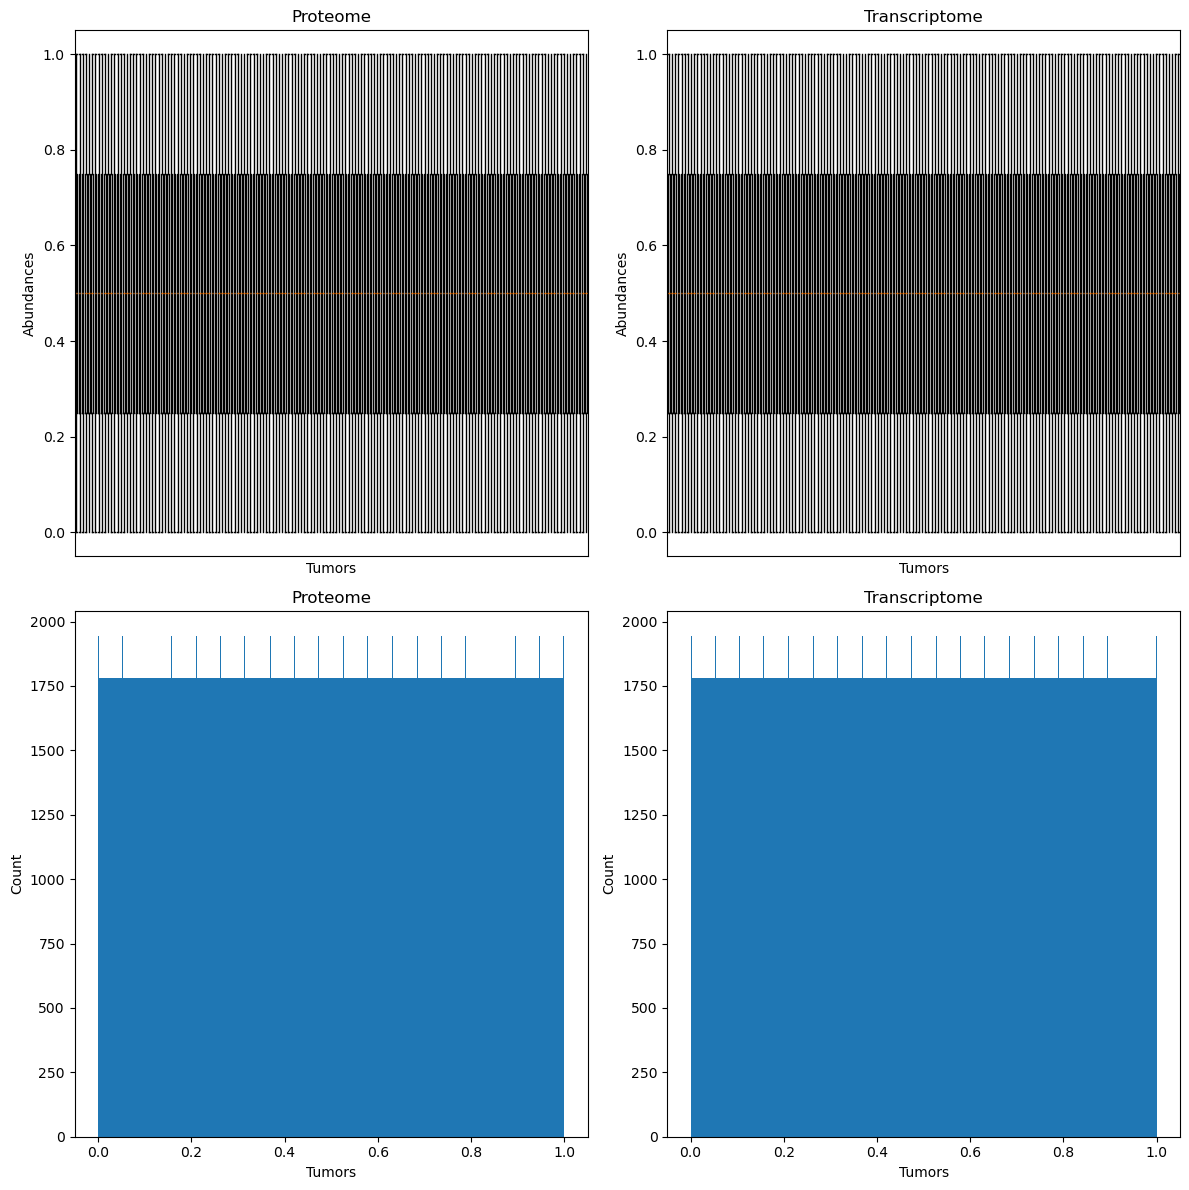

In [113]:
VisualizeData(J_PD_qt_tumor, J_MD_qt_tumor)

### Preparing data for Joint Johansson and Mertins

#### Raw data processing

In [96]:
# Johansson data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
#J_PFP = 'jo_protein_log2.csv' # proteomics file path, normalized by pool, log2 transformed.
J_PFP = 'johansson prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
J_PD = pd.read_csv(raw_data_path+J_PFP)

# Sort the column names in the dataframe
J_PD = J_PD.reindex(sorted(J_PD.columns), axis=1)

# # Data set wrangling
J_PD.index = J_PD.loc[:,'Index']
J_PD = J_PD.loc[:,J_PD.columns!='Index'] # Shape (12811, 45)
J_PD.dropna(inplace=True) # Shape (10559, 45)

# Open the mRNA data and only keep genes (rows) that are fully quantified
J_MFP = 'jo_mrna_dropna_newtumorid.csv' # mRNA file path, gene centric median normalized, log2 transformed
J_MD = pd.read_csv(raw_data_path + J_MFP)

# Sort the column names in both dataframe
J_MD = J_MD.reindex(sorted(J_MD.columns), axis=1)

# Data set wrangling
J_MD.index = J_MD.loc[:,'Unnamed: 0']
J_MD = J_MD.loc[:,J_MD.columns!='Unnamed: 0'] # Shape (32369, 45)
J_MD.dropna(inplace=True) # (32368, 45)

# unlog the data
J_MD = 2**J_PD

In [97]:
# Mertins data set
# Open the proteomics data and only keep genes (rows) that are fully quantified
#M_PFP = 'me_protein_dropna.csv' # proteomics file path, normalized by pool, log2 transformed.
M_PFP = 'mertins prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
M_PD = pd.read_csv(raw_data_path+M_PFP)

# Data set wrangling
M_PD.index = M_PD.loc[:,'Index']
M_PD = M_PD.loc[:,M_PD.columns!='Index'] # Shape (12302, 111)
M_PD.dropna(inplace=True) # Shape (7064, 111)

# Remove tumors that contain keyword 'notinstudy': 28 tumors are not in the study
M_PD = M_PD.loc[:,~M_PD.columns.str.contains('notinstudy')]

# Find tumors that contain keyword 'REP'
M_PD_rep_cols = M_PD.columns[M_PD.columns.str.contains('REP')]

# Extract tumors' name that has replicates
M_PD_rep_tumors = set(col.split('.')[0] for col in M_PD_rep_cols)

# Find columns that match the names in rep_tumors, take average and save it under the tumor name that without REP
for M_PD_rep_tumor in M_PD_rep_tumors:
    M_PD_replicates = M_PD.columns[M_PD.columns.str.contains(M_PD_rep_tumor)]
    M_PD[M_PD_rep_tumor] = M_PD[M_PD_replicates].mean(axis=1) # Overwrite the original tumor with the average of the replicates
    # Drop the REP column of the rep_tumor only
    M_PD_replicate_cols = M_PD.columns[M_PD.columns.str.contains(M_PD_rep_tumor+'.REP')]
    M_PD.drop(M_PD_replicate_cols, axis=1, inplace=True) # Drop the replicate columns

# Sort the column names in the dataframe
M_PD = M_PD.reindex(sorted(M_PD.columns), axis=1) # Shape (7064, 77)

# Open the mRNA data and only keep genes (rows) that are fully quantified
#M_MFP = 'me_rna_dropna.csv' # mRNA file path, gene centric median normalized, log2 transformed
M_MFP = 'mertins mrna model use.csv' # TPM data, untransformed
M_MD = pd.read_csv(raw_data_path+M_MFP)

# Data set wrangling
M_MD.index = M_MD.loc[:,'gene_name']
M_MD = M_MD.loc[:,M_MD.columns!='gene_name'] # Shape (19938, 77)

#M_MD = M_MD.drop_duplicates() # Shape (19292, 77)

M_MD.dropna(inplace=True) # Shape (19292, 77)

# Drop if any gene that contains 0 read of TPM (5063 genes are dropped, still have 6706 in common with PD)
M_MD = M_MD.loc[~(M_MD==0).any(axis=1)] # Shape (14229, 77)

# Sort the column names in the dataframe
M_MD = M_MD.reindex(sorted(M_MD.columns), axis=1) # Shape (14229, 77)

#### Normalization

In [98]:
J_PD_norm = Normalization(J_PD)
J_MD_norm = Normalization(J_MD)

M_PD_norm = Normalization(M_PD)
M_MD_norm = Normalization(M_MD)

#### Filter out genes that has labels

In [ ]:
# Open the labels data
#LFP = 'SubCellBarcode.MCF7.txt'
LFP = 'markers_mcf7_all.txt'
LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')

# Data set wrangling
LD.index = LD.loc[:,'Protein']
LD = LD.loc[:,LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = LD.loc[:,'Localization'] != 'Unclassified'
LD = LD.loc[NotUnclassInd,:]

In [100]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in M_PD_norm.index if ((value in M_MD_norm.index) & (value in J_MD_norm.index) & (value in J_PD_norm.index) & (value in LD.index))]
M_PD_norm = M_PD_norm.loc[IntersectingGenes,:]
M_MD_norm = M_MD_norm.loc[IntersectingGenes,:]
J_PD_norm = J_PD_norm.loc[IntersectingGenes,:]
J_MD_norm = J_MD_norm.loc[IntersectingGenes,:]
LD = LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('Joint Johansson and Mertin')
print(len(M_PD_norm.index))
print(len(M_MD_norm.index))
print(len(J_PD_norm.index))
print(len(J_MD_norm.index))
print(len(LD.index))

Joint Johansson and Mertin
5520
5520
5520
5520
5520


In [101]:
# Merge the data sets
joint_PD_norm = pd.concat([M_PD_norm, J_PD_norm], axis=1)
joint_MD_norm = pd.concat([M_MD_norm, J_MD_norm], axis=1)

#### Inferencing

In [102]:
# Ensure reproducibility
set_seed(43)

# Synthetic tumors using gaussian KDE
joint_PD_norm, joint_MD_norm = Gaussian_KDE(joint_PD_norm, joint_MD_norm, Set)

three channel rgb dual
Synthetic data generated


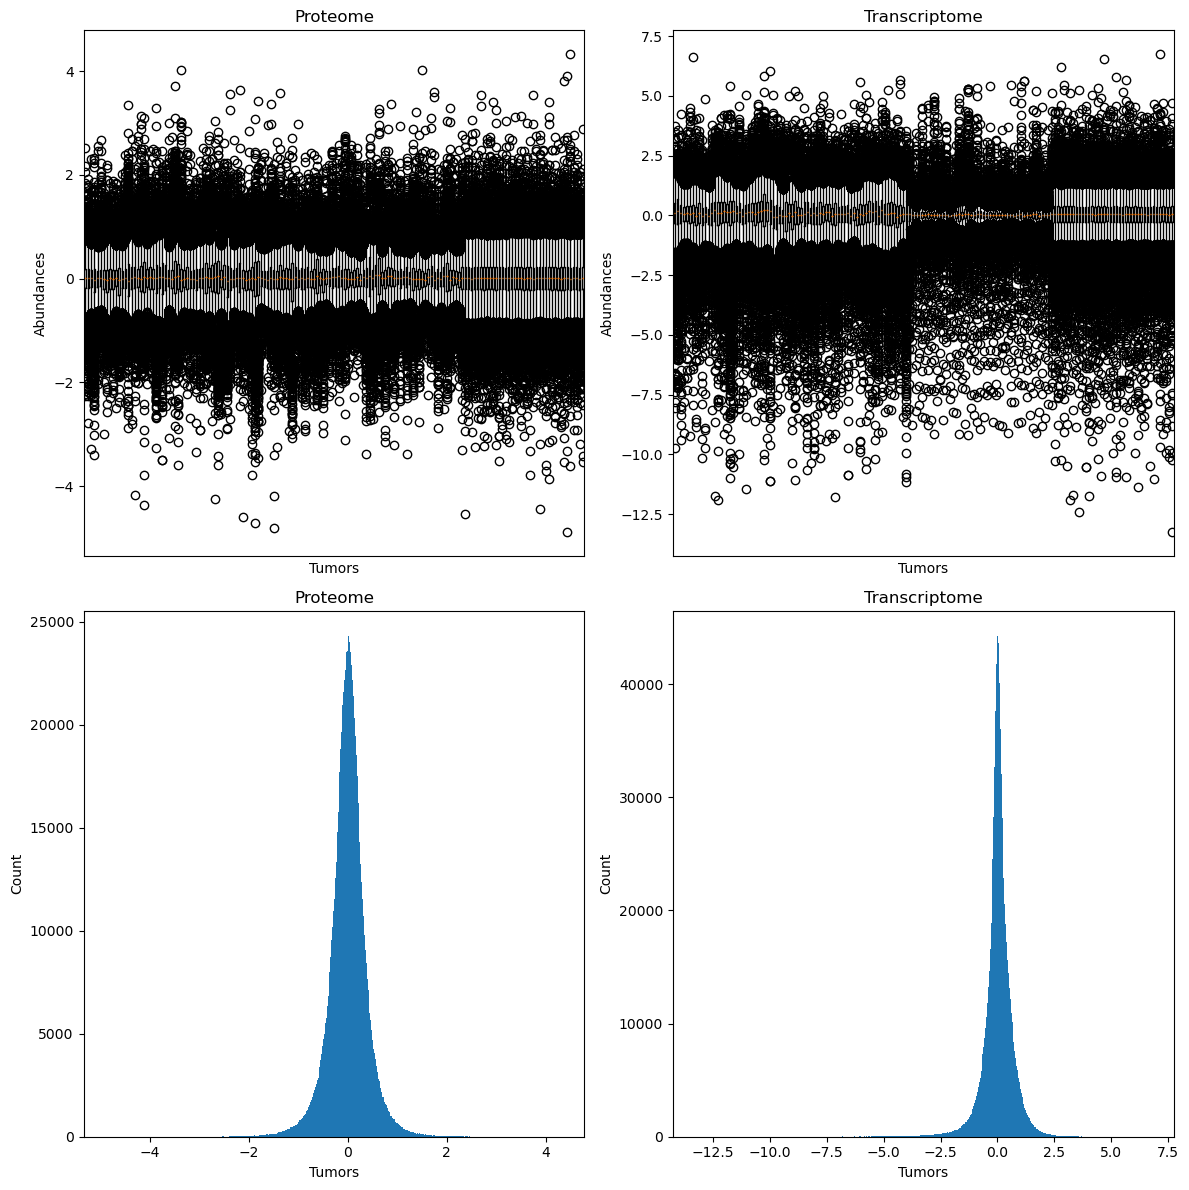

In [103]:
VisualizeData(joint_PD_norm, joint_MD_norm)

#### Scaling

In [104]:
#Quantile transformation
joint_PD_norm.columns = joint_PD_norm.columns.astype(str)
joint_MD_norm.columns = joint_MD_norm.columns.astype(str)

# Quantile transform each gene
#joint_PD_qt_gene = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=42).fit_transform(joint_PD_norm.T), index=joint_PD_norm.T.index, columns=joint_PD_norm.T.columns)
#joint_MD_qt_gene = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=43).fit_transform(joint_MD_norm.T), index=joint_MD_norm.T.index, columns=joint_MD_norm.T.columns)

# Quantile transform each tumor
joint_PD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=44).fit_transform(joint_PD_norm), index=joint_PD_norm.index, columns=joint_PD_norm.columns)
joint_MD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=45).fit_transform(joint_MD_norm), index=joint_MD_norm.index, columns=joint_MD_norm.columns)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (5520). n_quantiles is set to n_samples.
  warnings.warn(


/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (5520). n_quantiles is set to n_samples.
  warnings.warn(


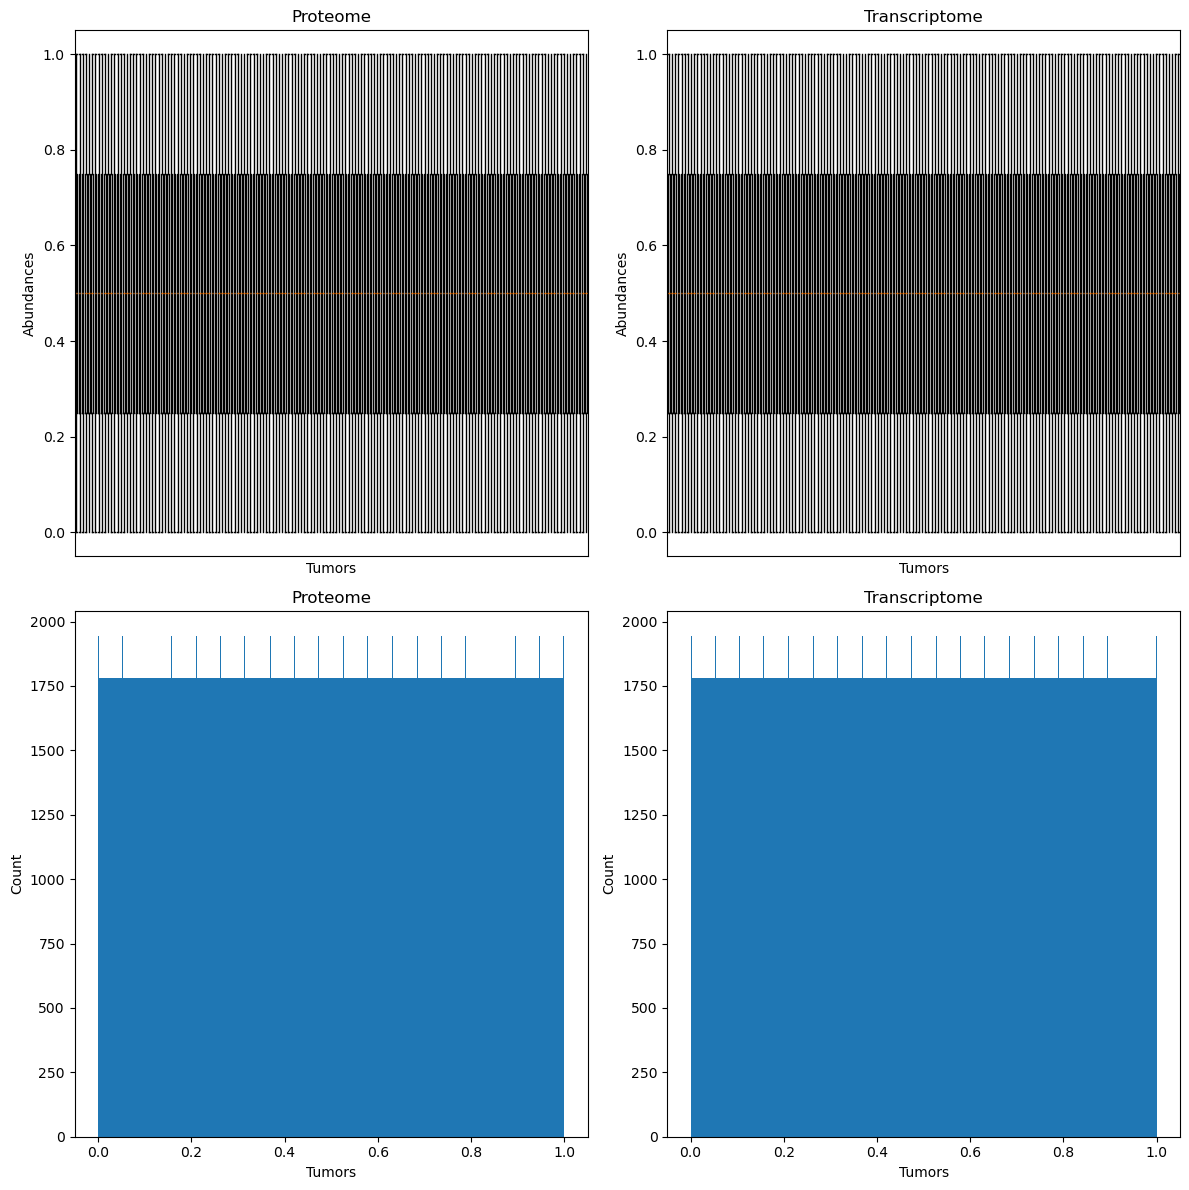

In [105]:
VisualizeData(joint_PD_qt_tumor, joint_MD_qt_tumor)

### Preparing data for LCSCC Tumor

#### Raw data processing

In [98]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
lung_tumor_PFP = 'lcscc tumor prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
lung_tumor_PD = pd.read_csv(raw_data_path+lung_tumor_PFP, index_col=0) # Shape (13506, 108)

# Remove NA
lung_tumor_PD.dropna(inplace=True) # Shape (9051, 108)

# Check if any index is duplicated, if so, average the duplicates
lung_tumor_PD = lung_tumor_PD.groupby(lung_tumor_PD.index).mean()

# Sort the column names in the dataframe
lung_tumor_PD = lung_tumor_PD.reindex(sorted(lung_tumor_PD.columns), axis=1) # Shape (8481, 108)

In [99]:
# Open the mRNA data and only keep genes (rows) that are fully quantified
lung_tumor_MFP = 'lcscc tumor mrna model use.csv' # TPM data, untransformed
lung_tumor_MD = pd.read_csv(raw_data_path+lung_tumor_MFP, index_col=0) # Shape (19938, 108)

# Data set wrangling
lung_tumor_MD.dropna(inplace=True) # Shape (19938, 108)

# Drop if any gene that contains 0 read of TPM
lung_tumor_MD = lung_tumor_MD.loc[~(lung_tumor_MD==0).any(axis=1)] # Shape (15387, 108)

# Check if any index is duplicated, if so, average the duplicates
lung_tumor_MD = lung_tumor_MD.groupby(lung_tumor_MD.index).mean()

# Sort the column names in the dataframe
lung_tumor_MD = lung_tumor_MD.reindex(sorted(lung_tumor_MD.columns), axis=1) # Shape (15387, 108)

#### Normalization

In [100]:
# Visualize the processed data with boxplot and histogram
lung_tumor_PD_norm = Normalization(lung_tumor_PD)
lung_tumor_MD_norm = Normalization(lung_tumor_MD)

#### Filter out genes that has labels

In [101]:
# Open the labels data
LFP = 'markers.txt'
lung_tumor_LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')

# Data set wrangling
lung_tumor_LD.index = lung_tumor_LD.loc[:,'Protein']
lung_tumor_LD = lung_tumor_LD.loc[:,lung_tumor_LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = lung_tumor_LD.loc[:,'Localization'] != 'Unclassified'
lung_tumor_LD = lung_tumor_LD.loc[NotUnclassInd,:]

In [102]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in lung_tumor_PD_norm.index if ((value in lung_tumor_MD_norm.index) & (value in lung_tumor_LD.index))]
lung_tumor_PD_norm = lung_tumor_PD_norm.loc[IntersectingGenes,:]
lung_tumor_MD_norm = lung_tumor_MD_norm.loc[IntersectingGenes,:]
lung_tumor_LD = lung_tumor_LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('LCSCC Tumor')
print(len(lung_tumor_PD_norm.index))
print(len(lung_tumor_MD_norm.index))
print(len(lung_tumor_LD.index))

LCSCC Tumor
2788
2788
2788


In [103]:
# Count the number of genes in each localization class
LocalizationCounts = lung_tumor_LD.loc[:,'Localization'].value_counts()
print('Number of genes in each localization class:')
print(LocalizationCounts)

Number of genes in each localization class:
Localization
Cytosol         1035
Secretory        864
Nucleus          624
Mitochondria     265
Name: count, dtype: int64


#### Inferencing

In [104]:
# Ensure reproducibility
set_seed(46)

# Synthetic tumors using gaussian KDE
lung_tumor_PD_norm, lung_tumor_MD_norm = Gaussian_KDE(lung_tumor_PD_norm, lung_tumor_MD_norm, Set)

three channel rgb dual
Synthetic data generated


#### Scaling

In [105]:
#Quantile transformation
lung_tumor_PD_norm.columns = lung_tumor_PD_norm.columns.astype(str)
lung_tumor_MD_norm.columns = lung_tumor_MD_norm.columns.astype(str)

# Quantile transform each tumor
lung_tumor_PD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=46).fit_transform(lung_tumor_PD_norm), index=lung_tumor_PD_norm.index, columns=lung_tumor_PD_norm.columns)
lung_tumor_MD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=47).fit_transform(lung_tumor_MD_norm), index=lung_tumor_MD_norm.index, columns=lung_tumor_MD_norm.columns)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2788). n_quantiles is set to n_samples.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2788). n_quantiles is set to n_samples.
  warnings.warn(


### Preparing data for LCSCC NAT

#### Raw data processing

In [106]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
lung_nat_PFP = 'lcscc nat prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
lung_nat_PD = pd.read_csv(raw_data_path+lung_nat_PFP, index_col=0) # Shape (13506, 94)

# Remove NA
lung_nat_PD.dropna(inplace=True) # Shape (9047, 94)

# Check if any index is duplicated, if so, average the duplicates
lung_nat_PD = lung_nat_PD.groupby(lung_nat_PD.index).mean() # Shape (9041, 94)

# Sort the column names in the dataframe
lung_nat_PD = lung_nat_PD.reindex(sorted(lung_nat_PD.columns), axis=1) # Shape (9041, 94)

In [107]:
# Open the mRNA data and only keep genes (rows) that are fully quantified
lung_nat_MFP = 'lcscc nat mrna model use.csv' # TPM data, untransformed
lung_nat_MD = pd.read_csv(raw_data_path+lung_nat_MFP, index_col=0) # Shape (19938, 94)

# Data set wrangling
lung_nat_MD.dropna(inplace=True) # Shape (19938, 94)

# Drop if any gene that contains 0 read of TPM
lung_nat_MD = lung_nat_MD.loc[~(lung_nat_MD==0).any(axis=1)] # Shape (16095, 94)

# Check if any index is duplicated, if so, average the duplicates
lung_nat_MD = lung_nat_MD.groupby(lung_nat_MD.index).mean() # Shape (16095, 94)

# Sort the column names in the dataframe
lung_nat_MD = lung_nat_MD.reindex(sorted(lung_nat_MD.columns), axis=1) # Shape (16095, 94)

#### Normalization

In [108]:
# Visualize the processed data with boxplot and histogram
lung_nat_PD_norm = Normalization(lung_nat_PD)
lung_nat_MD_norm = Normalization(lung_nat_MD)

#### Filter out genes that has labels

In [109]:
# Open the labels data
LFP = 'markers.txt'
lung_nat_LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')

# Data set wrangling
lung_nat_LD.index = lung_nat_LD.loc[:,'Protein']
lung_nat_LD = lung_nat_LD.loc[:,lung_nat_LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = lung_nat_LD.loc[:,'Localization'] != 'Unclassified'
lung_nat_LD = lung_nat_LD.loc[NotUnclassInd,:]

In [110]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in lung_nat_PD_norm.index if ((value in lung_nat_MD_norm.index) & (value in lung_nat_LD.index))]
lung_nat_PD_norm = lung_nat_PD_norm.loc[IntersectingGenes,:]
lung_nat_MD_norm = lung_nat_MD_norm.loc[IntersectingGenes,:]
lung_nat_LD = lung_nat_LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('LCSCC nat')
print(len(lung_nat_PD_norm.index))
print(len(lung_nat_MD_norm.index))
print(len(lung_nat_LD.index))

LCSCC nat
2789
2789
2789


In [111]:
# Count the number of genes in each localization class
LocalizationCounts = lung_nat_LD.loc[:,'Localization'].value_counts()
print('Number of genes in each localization class:')
print(LocalizationCounts)

Number of genes in each localization class:
Localization
Cytosol         1036
Secretory        864
Nucleus          624
Mitochondria     265
Name: count, dtype: int64


#### Inferencing

In [112]:
# Ensure reproducibility
set_seed(48)

# Synthetic tumors using gaussian KDE
lung_nat_PD_norm, lung_nat_MD_norm = Gaussian_KDE(lung_nat_PD_norm, lung_nat_MD_norm, Set)

three channel rgb dual
Synthetic data generated


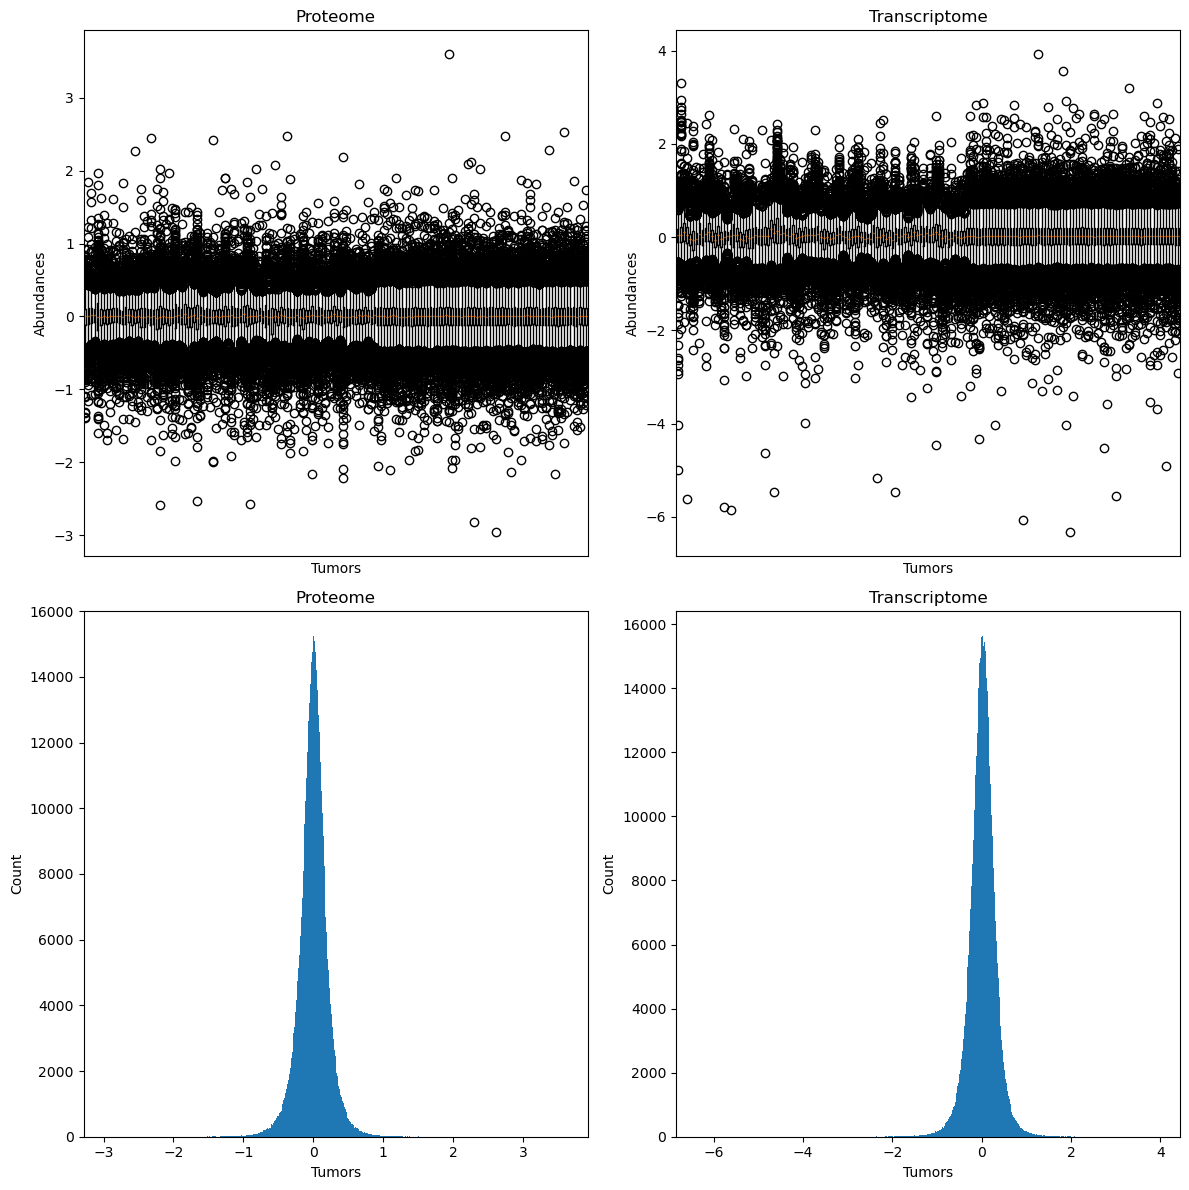

In [113]:
VisualizeData(lung_nat_PD_norm, lung_nat_MD_norm)

#### Scaling

In [114]:
#Quantile transformation
lung_nat_PD_norm.columns = lung_nat_PD_norm.columns.astype(str)
lung_nat_MD_norm.columns = lung_nat_MD_norm.columns.astype(str)

# Quantile transform each tumor
lung_nat_PD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=48).fit_transform(lung_nat_PD_norm), index=lung_nat_PD_norm.index, columns=lung_nat_PD_norm.columns)
lung_nat_MD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=49).fit_transform(lung_nat_MD_norm), index=lung_nat_MD_norm.index, columns=lung_nat_MD_norm.columns)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2789). n_quantiles is set to n_samples.
  warnings.warn(


/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2789). n_quantiles is set to n_samples.
  warnings.warn(


### Preparing data for Gliomas

#### Raw data processing

In [115]:
# Open the proteomics data and only keep genes (rows) that are fully quantified
glioma_tumor_PFP = 'glioma prot model use.csv' # MSFragger search, abundances are ratio of channel to pool, no transformation
glioma_tumor_PD = pd.read_csv(raw_data_path+glioma_tumor_PFP, index_col=0) # Shape (13295, 150)

# Remove columns that contain 'Disqualified' 
glioma_tumor_PD = glioma_tumor_PD.loc[:,~glioma_tumor_PD.columns.str.contains('Disqualified')] # Shape (13295, 148)

# Remove columns that contain 'Recurrent'
glioma_tumor_PD = glioma_tumor_PD.loc[:,~glioma_tumor_PD.columns.str.contains('Recurrent')] # Shape (13295, 123)

# Remove columns that contain 'Metastatic'
glioma_tumor_PD = glioma_tumor_PD.loc[:,~glioma_tumor_PD.columns.str.contains('Metastatic')] # Shape (13295, 111)

# Remove columns that contain 'Solid-Tissue-Normal'
glioma_tumor_PD = glioma_tumor_PD.loc[:,~glioma_tumor_PD.columns.str.contains('Solid-Tissue-Normal')] # Shape (13295, 103)

# Check if how many columns contain 'ref2'
glioma_tumor_PD = glioma_tumor_PD.loc[:,~glioma_tumor_PD.columns.str.contains('ref2')] # Shape (13295, 102)

# Modify the column names to remove '-Primary-Tumor'
glioma_tumor_PD.columns = glioma_tumor_PD.columns.str.replace('-Primary-Tumor', '') # Shape (13295, 102)

# Remove NA
glioma_tumor_PD.dropna(inplace=True) # Shape (8589, 102)

# Check if any index is duplicated, if so, average the duplicates
glioma_tumor_PD = glioma_tumor_PD.groupby(glioma_tumor_PD.index).mean() # Shape (8580, 102)

# Sort the column names in the dataframe
glioma_tumor_PD = glioma_tumor_PD.reindex(sorted(glioma_tumor_PD.columns), axis=1) # Shape (8580, 102)

In [116]:
# Open the mRNA data and only keep genes (rows) that are fully quantified
glioma_tumor_MFP = 'glioma mrna model use.csv' # TPM data, untransformed
glioma_tumor_MD = pd.read_csv(raw_data_path+glioma_tumor_MFP, index_col=0) # Shape (19938, 203)

# Data set wrangling
glioma_tumor_MD.dropna(inplace=True) # Shape (19938, 203)

# Drop if any gene that contains 0 read of TPM
glioma_tumor_MD = glioma_tumor_MD.loc[~(glioma_tumor_MD==0).any(axis=1)] # Shape (15010, 203)

# Check if any index is duplicated, if so, average the duplicates
glioma_tumor_MD = glioma_tumor_MD.groupby(glioma_tumor_MD.index).mean() # Shape (15010, 203)

# Sort the column names in the dataframe
glioma_tumor_MD = glioma_tumor_MD.reindex(sorted(glioma_tumor_MD.columns), axis=1) # Shape (15010, 203)

In [117]:
# get the column names that are common in proteome and mRNA data sets
common_col = [col for col in glioma_tumor_PD.columns if col in glioma_tumor_MD.columns]

# filter the columns in both data sets
glioma_tumor_PD = glioma_tumor_PD.loc[:,common_col] # shape (8580, 99)
glioma_tumor_MD = glioma_tumor_MD.loc[:,common_col] # shape (15010, 99)

#### Normalization

In [118]:
# Visualize the processed data with boxplot and histogram
glioma_tumor_PD_norm = Normalization(glioma_tumor_PD)
glioma_tumor_MD_norm = Normalization(glioma_tumor_MD)

#### Filter out genes that has labels

In [119]:
# Open the labels data
LFP = 'markers.txt'
glioma_tumor_LD = pd.read_csv(filepath_or_buffer=label_path+LFP,sep='\t')

# Data set wrangling
glioma_tumor_LD.index = glioma_tumor_LD.loc[:,'Protein']
glioma_tumor_LD = glioma_tumor_LD.loc[:,glioma_tumor_LD.columns!='Protein']

# Remove unclassified class
NotUnclassInd = glioma_tumor_LD.loc[:,'Localization'] != 'Unclassified'
glioma_tumor_LD = glioma_tumor_LD.loc[NotUnclassInd,:]

In [120]:
# Keep only genes (rows) are presented in proteome, mRNA and localization data sets
IntersectingGenes = [value for value in glioma_tumor_PD_norm.index if ((value in glioma_tumor_MD_norm.index) & (value in glioma_tumor_LD.index))]
glioma_tumor_PD_norm = glioma_tumor_PD_norm.loc[IntersectingGenes,:]
glioma_tumor_MD_norm = glioma_tumor_MD_norm.loc[IntersectingGenes,:]
glioma_tumor_LD = glioma_tumor_LD.loc[IntersectingGenes,:]

# Sanity check for the number of genes in each dataframe
print('glioma tumor')
print(len(glioma_tumor_PD_norm.index))
print(len(glioma_tumor_MD_norm.index))
print(len(glioma_tumor_LD.index))

glioma tumor
2679
2679
2679


In [121]:
# count the number of different labels
print(glioma_tumor_LD['Localization'].value_counts())

Localization
Cytosol         1013
Secretory        847
Nucleus          553
Mitochondria     266
Name: count, dtype: int64


#### Inferencing

In [122]:
# Ensure reproducibility
set_seed(50)

# Synthetic tumors using gaussian KDE
glioma_tumor_PD_norm, glioma_tumor_MD_norm = Gaussian_KDE(glioma_tumor_PD_norm, glioma_tumor_MD_norm, Set)

three channel rgb dual
Synthetic data generated


#### Scaling

In [123]:
#Quantile transformation
glioma_tumor_PD_norm.columns = glioma_tumor_PD_norm.columns.astype(str)
glioma_tumor_MD_norm.columns = glioma_tumor_MD_norm.columns.astype(str)

# Quantile transform each tumor
glioma_tumor_PD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=50).fit_transform(glioma_tumor_PD_norm), index=glioma_tumor_PD_norm.index, columns=glioma_tumor_PD_norm.columns)
glioma_tumor_MD_qt_tumor = pd.DataFrame(QuantileTransformer(n_quantiles = 10000, output_distribution='uniform',random_state=51).fit_transform(glioma_tumor_MD_norm), index=glioma_tumor_MD_norm.index, columns=glioma_tumor_MD_norm.columns)

/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2679). n_quantiles is set to n_samples.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10000) is greater than the total number of samples (2679). n_quantiles is set to n_samples.
  warnings.warn(


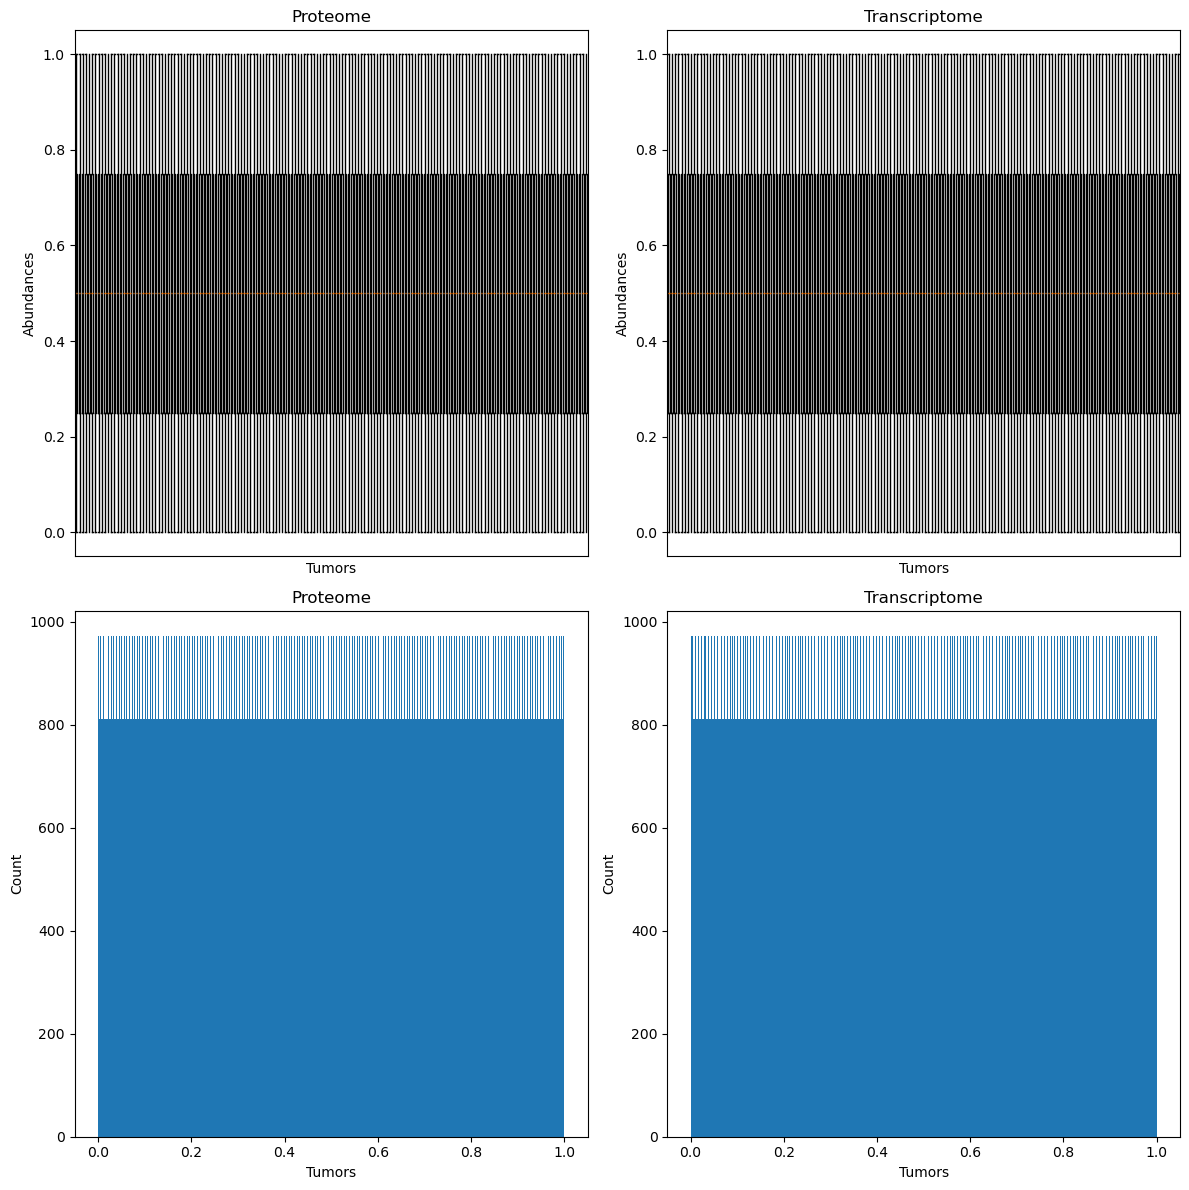

In [124]:
VisualizeData(glioma_tumor_PD_qt_tumor, glioma_tumor_MD_qt_tumor)

### Export

#### Krug

In [125]:
# Export
if Set == 'three channel rgb dual':
    PD_qt_tumor.to_csv(Path(output_path + 'K_PD_synthetic_kde_qttumor.csv'))
    MD_qt_tumor.to_csv(Path(output_path + 'K_MD_synthetic_kde_qttumor.csv'))

#### Mertins

In [126]:
# Export
if Set == 'three channel rgb dual':
    M_PD_qt_tumor.to_csv(Path(output_path + 'M_PD_synthetic_kde_qttumor.csv'))
    M_MD_qt_tumor.to_csv(Path(output_path + 'M_MD_synthetic_kde_qttumor.csv'))

#### Johansson

In [ ]:
# Export
if Set == 'three channel rgb dual':
    #J_PD_qt_gene.T.to_csv(Path(output_path + 'J_PD_synthetic_kde_qtgene.csv'))
    #J_PD_qt_tumor.to_csv(Path(output_path + 'J_PD_synthetic_kde_qttumor_5520.csv'))

    #J_MD_qt_gene.T.to_csv(Path(output_path + 'J_MD_synthetic_kde_qtgene.csv'))
    #J_MD_qt_tumor.to_csv(Path(output_path + 'J_MD_synthetic_kde_qttumor_5520.csv'))
elif Set == 'three channel rgb single':
    #J_PD_qt_tumor.to_csv(Path(output_path + 'J_PD_synthetic_kde_qttumor_single_5520.csv'))
    #J_MD_qt_tumor.to_csv(Path(output_path + 'J_MD_synthetic_kde_qttumor_single_5520.csv'))

#### Joint J M

In [ ]:
# Export
if Set == 'three channel rgb dual':
    #joint_PD_qt_tumor.to_csv(Path(output_path + 'Joint_PD_synthetic_kde_qttumor.csv'))
    #joint_MD_qt_tumor.to_csv(Path(output_path + 'Joint_MD_synthetic_kde_qttumor.csv'))
elif Set == 'three channel rgb single':
    #joint_PD_qt_tumor.to_csv(Path(output_path + 'Joint_PD_synthetic_kde_qttumor_single.csv'))
    #joint_MD_qt_tumor.to_csv(Path(output_path + 'Joint_MD_synthetic_kde_qttumor_single.csv'))

#### LCSCC Tumor

In [127]:
# Export
if Set == 'three channel rgb dual':
    lung_tumor_PD_qt_tumor.to_csv(Path(output_path + 'lung_tumor_PD_synthetic_kde_qttumor.csv'))
    lung_tumor_MD_qt_tumor.to_csv(Path(output_path + 'lung_tumor_MD_synthetic_kde_qttumor.csv'))

#### LCSCC NAT

In [128]:
# Export
if Set == 'three channel rgb dual':
    lung_nat_PD_qt_tumor.to_csv(Path(output_path + 'lung_nat_PD_synthetic_kde_qttumor.csv'))
    lung_nat_MD_qt_tumor.to_csv(Path(output_path + 'lung_nat_MD_synthetic_kde_qttumor.csv'))

#### Brain glioma

In [129]:
# Export
if Set == 'three channel rgb dual':
    glioma_tumor_PD_qt_tumor.to_csv(Path(output_path + 'glioma_tumor_PD_synthetic_kde_qttumor.csv'))
    glioma_tumor_MD_qt_tumor.to_csv(Path(output_path + 'glioma_tumor_MD_synthetic_kde_qttumor.csv'))